In [1]:
%matplotlib inline 

from imports import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


(64, 64)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\metrics\simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


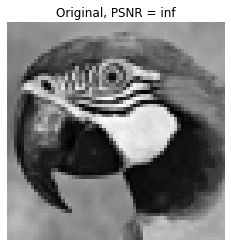

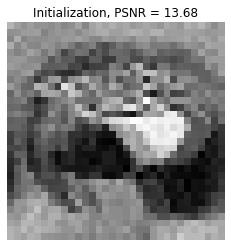

In [2]:
problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=64, W=64, sigma=.1, subsampling=2)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=64, W=64)

noisy = problem.noisy
noisy = (noisy - noisy.min()) / (noisy.max() - noisy.min())
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=64, W=64)

(-0.5, 31.5, 31.5, -0.5)

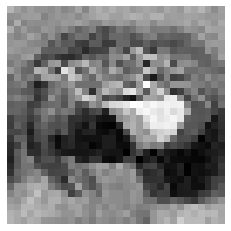

In [3]:
measurements = problem.y.reshape(32,32)
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [ ]:
denoiser = NLMDenoiser(filter_decay=0.999,
                       filter_size=0.03, patch_size=5, patch_distance=12, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=.000001, tt=5, T2=1, 
                                                   mini_batch_size=problem.num_meas, verbose=True)

psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(64,64), title="SVRG", H=64, W=64)